In [ ]:
from shapely.geometry import Polygon  
from shapely import affinity    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from utils import SensorCamera,Tree
from utils import lawmowerPath
import random
from shapely.ops import unary_union

#random.seed(42)  # For reproducibility

#DJImini3Camera = SensorCamera(9.6,9.6,4032,4032)
DJImini3Camera = SensorCamera()
desirableGSD = 1*0.43 #cm/px
altitude = DJImini3Camera.h_desirable(desirableGSD)/100
width,height = DJImini3Camera.l(altitude) # dimensão horizontal do sensor para a altitude desejada
L = 8
poly = Polygon([(-L*height, -L*width), (L*height, -L*width), (L*height, L*width), (-L*height, L*width)])
angle_deg = 0  # ângulo da varredura em graus (0 = horizontal, 90 = vertical)
waypointsLawMower = lawmowerPath(poly, height, width, angle_deg)

areas_de_interesse = []
base = Polygon([(-height/2, -width/2), (height/2,-width/2), (height/2,width/2), (-height/2,width/2)])

p = 5
cont = 0
interesting_area = 0
while interesting_area < p/100:

    i = random.normalvariate(0.0,0.3) #random.uniform(-0.95,0.95)
    j = random.normalvariate(0.0,0.3) #random.uniform(-0.95,0.95)     
    poly_rand = affinity.translate(base, i*L*height, j*L*width)
    areas_de_interesse.append(poly_rand)
    areas_unidas = unary_union(areas_de_interesse)
    interesting_area = poly.intersection(areas_unidas).area
    interesting_area = interesting_area /poly.area
              
areas_de_interesse2 = [areas_unidas]
print("p =", np.round(interesting_area * 100,2), "%", "interesting")
print("C =", len(areas_de_interesse), "patches")


p = 20.05 % interesting
C = 273 patches


In [46]:
from utils import Shortcut, DeepFirst, BreadthFirst

altitude2 = DJImini3Camera.h_desirable(4*desirableGSD)/100
width2,height2 = DJImini3Camera.l(altitude2) # dimensão horizontal do sensor para a altitude desejada
waypointsInitial = lawmowerPath(poly, height2, width2, angle_deg)

LawnmowerTree = Tree(sensorCamera=DJImini3Camera)
BFTree = BreadthFirst(DJImini3Camera,areas_de_interesse2)
ShortTree = Shortcut(DJImini3Camera,areas_de_interesse2)
DFTree = DeepFirst(DJImini3Camera,areas_de_interesse2)
DFTreeHilbert = DeepFirst(DJImini3Camera,areas_de_interesse2)
LawnmowerTree.add_fistLevel_nodes(waypointsLawMower, altitude,width,height)
BFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
ShortTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)

In [47]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list(
    "azul_verde_vermelho",
    [(0.0, "blue"), (0.5, "green"), (1.0, "red")]
)

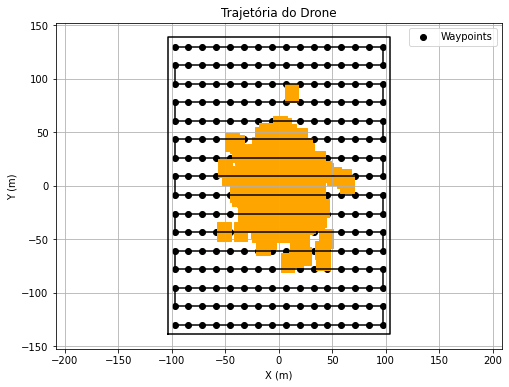

Coverage Path length (LawMower):  3.3808320000000154  km


In [48]:
waypoints = np.array(waypointsLawMower)
fig, ax = plt.subplots(figsize=(8, 6))
waypoints_x = [wp[0] for wp in waypoints]
waypoints_y = [wp[1] for wp in waypoints]
ax.scatter(waypoints_x, waypoints_y, color='black', label='Waypoints', marker='o')
ax.plot(waypoints_x, waypoints_y, color='black')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')

for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.fill(x, y, color='Orange')

plt.title('Trajetória do Drone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
path_length5 = 0
for i in range(np.size(waypoints,0)-1):
    path_length5 += np.linalg.norm(waypoints[i+1] - waypoints[i])
print("Coverage Path length (LawMower): ", path_length5/1000, " km")

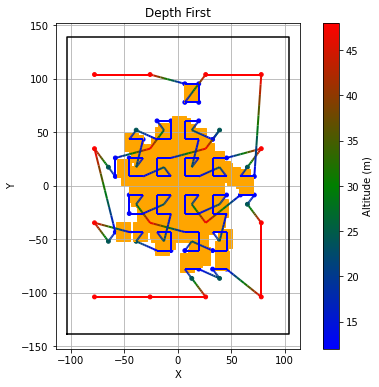

Coverage Path length (Depth First):  2.6092053882907065  km


In [49]:
waypointsDF = np.array(DFTree.generate_path())

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsDF) - 1):
    segment = interp_segment(waypointsDF[i], waypointsDF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsDF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsDF[:, 0], waypointsDF[:, 1], c=waypointsDF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')

for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.fill(x, y, color='Orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Depth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length4 = 0
for i in range(np.size(waypointsDF,0)-1):
    path_length4 += np.linalg.norm(waypointsDF[i+1] - waypointsDF[i])
print("Coverage Path length (Depth First): ", path_length4/1000, " km")

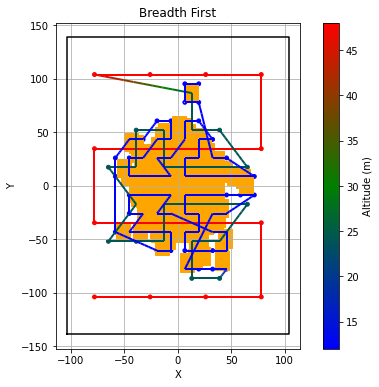

Coverage Path length (Breadth First):  2.898507610215988  km


In [50]:
waypointsBF = np.array(BFTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsBF) - 1):
    segment = interp_segment(waypointsBF[i], waypointsBF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsBF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsBF[:, 0], waypointsBF[:, 1], c=waypointsBF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')

for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.fill(x, y, color='Orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Breadth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length3 = 0
for i in range(np.size(waypointsBF,0)-1):
    path_length3 += np.linalg.norm(waypointsBF[i+1] - waypointsBF[i])
print("Coverage Path length (Breadth First): ", path_length3/1000, " km")

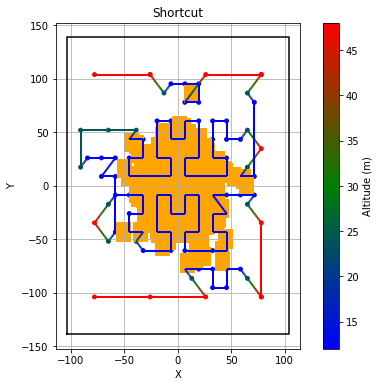

Coverage Path length (Shortcut):  2.1797116928726785  km


In [51]:
waypointsSC = np.array(ShortTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsSC) - 1):
    segment = interp_segment(waypointsSC[i], waypointsSC[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsSC[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsSC[:, 0], waypointsSC[:, 1], c=waypointsSC[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')

for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.fill(x, y, color='Orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Shortcut")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(0,np.size(waypointsSC,0)-1):
    path_length += np.linalg.norm(waypointsSC[i+1] - waypointsSC[i])
print("Coverage Path length (Shortcut): ", path_length/1000, " km")

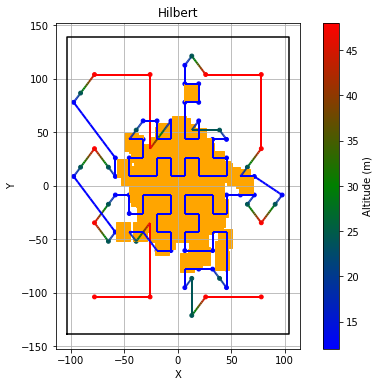

Coverage Path length Hilbert:  2.3577115176218166  km


In [52]:
from utils import HilbertTree
DFTreeHilbert = HilbertTree(DJImini3Camera,areas_de_interesse)
DFTreeHilbert.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTreeHilbert.add_another_levels()

waypoints = np.array(DFTreeHilbert.generate_path())

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypoints) - 1):
    segment = interp_segment(waypoints[i], waypoints[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypoints[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypoints[:, 0], waypoints[:, 1], c=waypoints[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')

for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.fill(x, y, color='Orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Hilbert")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length2 = 0
for i in range(0,np.size(waypoints,0)-1):
    path_length2 += np.linalg.norm(waypoints[i+1] - waypoints[i])
print("Coverage Path length Hilbert: ", path_length2/1000, " km")

In [53]:
print("Coverage Path length (Shortcut Hilbert): ", path_length2/path_length5)
print("Coverage Path length (Shortcut): ", path_length/path_length5)
print("Coverage Path length (Depth First): ", path_length4/path_length5)
print("Coverage Path length (Breadth First): ", path_length3/path_length5)
print("Coverage Path length (LawMower): ", path_length5/path_length5)

Coverage Path length (Shortcut Hilbert):  0.6973761244633883
Coverage Path length (Shortcut):  0.6447264143479087
Coverage Path length (Depth First):  0.7717642841438719
Coverage Path length (Breadth First):  0.8573355937875572
Coverage Path length (LawMower):  1.0


In [54]:
print(np.linalg.norm(waypoints[2] - waypoints[3]))
print(height)
print(np.linalg.norm(waypoints[3] - waypoints[4]))
print(width)


32.351605463098736
13.003199999999998
16.175802731549364
17.337599999999995
